In [34]:
import numpy as np
import torch
import time
import datetime
import random
import pdb

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import * # for pad_sequence and whatnot
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, RandomSampler, SequentialSampler

from torch.utils import data
from torchvision import transforms

import matplotlib.pyplot as plt
import time

import json
import pickle 

from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import logging
logging.basicConfig(level=logging.INFO)

from BERT_train_test import train, test
from BERT_preprocessing_text import PreprocessedData

cuda = torch.cuda.is_available()
print(cuda)
device = torch.device("cuda" if cuda else "cpu")

True


In [35]:
design_tagged_p ='./data/design_dz-cleaned-tagged.json'
arch_tagged_p ='./data/architecture_dz-cleaned-tagged.json'
tech_tagged_p ='./data/technology_dz-cleaned-tagged.json'

design_ntag_p = '.data/design_dz-cleaned.json'
arch_ntag_p = './data/architecture_dz-cleaned.json'
tech_ntag_p = './data/technology_dz-cleaned.json'


In [68]:
def make_graph(epochs, plots, name_long, name_short, save_name):
    colors = ['darkturquoise', 'mediumvioletred', 'beige', 'brown', 'chartreuse', 'chocolate', 
              'coral', 'crimson', 'fusia', 'goldenrod', 'green', 'indigo', 'lavender', 'lightgreen', 
              'orange', 'orchid']
    print('pp')
    BCK = (1, 1, 1)
    fig, ax = plt.subplots(1)
    ax.set_facecolor(BCK)
    print('oo')
    for idx, p in enumerate(plots):
        data = p[0]
        name = p[1]
        color = colors[idx]
        ax.plot(epochs, data, label=name, c=color)
        
    ax.set_title(name_long)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(name_short)
    ax.legend()
    print('ii')
    plt.savefig(save_name, dpi=300)
    plt.clf()
    plt.close()
    plt.cla()
    print('hh')
    return

def save_json(file_path, data):
    out_file = open(file_path, "w")
    json.dump(data, out_file)
    out_file.close()


In [37]:
def run_epochs(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs, b, m, eq_name):
    start_time = time.time()

    train_losses, train_accs, train_precs, train_recalls, train_f1s = [], [], [], [], []
    test_losses, test_accs, test_precs, test_recalls, test_f1s = [], [], [], [], []
    best_f1 = 0
    for epoch in range(epochs):
        print('======== Epoch %d ========' % epoch)
        train_loss, train_acc, train_prec, train_recall, train_f1 = train(model, train_dataloader, optimizer, scheduler)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_precs.append(train_prec)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        test_loss, test_acc, test_prec, test_recall, test_f1 = test(model, validation_dataloader)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        test_precs.append(test_prec)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        
        if test_f1 > best_f1:
            best_f1 = test_f1
            name = 'best_epoch_{}_batch_size_{}_max_length_{}.pt'.format(eq_name, str(b), str(m))
            torch.save(model.state_dict(), name)
    
    print("Total training took %.2f seconds" % (time.time()-start_time))
    
    return train_losses, train_accs, train_precs, train_recalls, train_f1s, test_losses, test_accs, test_precs, test_recalls, test_f1s

In [38]:
def main():
    torch.cuda.empty_cache()
    MODEL_NAME = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    batches = [64, 32, 16, 8]
    max_lengths = [32, 64, 100]
    equal = [True, False]
    for eqs in equal:
        eq_name = 'equal' if eqs else 'unequal'
        results = dict()
        for b in batches:
            train_losses, train_accs, train_precs, train_recalls, train_f1s = [], [], [], [], []
            test_losses, test_accs, test_precs, test_recalls, test_f1s = [], [], [], [], []
            ms = []
            
            for m in max_lengths:
                # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
                batch_size = b
                max_length = m

                dataset = PreprocessedData([design_tagged_p, arch_tagged_p, tech_tagged_p], 
                                           [design_ntag_p, arch_ntag_p, tech_ntag_p], 
                                           tokenizer, max_length, eqs, './data')
                
                train_dataset = dataset.train_dataset
                dev_dataset = dataset.dev_dataset
                
                # We'll take training samples in random order. 
                train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
                validation_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=batch_size)

                # Load BertForSequenceClassification, the pretrained BERT model with a single 
                # linear classification layer on top. 
                model = BertForSequenceClassification.from_pretrained(
                    "bert-base-uncased",          # Use the 12-layer BERT model, with an uncased vocab.
                    num_labels = 2,               # The number of output labels--2 for binary classification. 
                    output_attentions = False,    # Whether the model returns attentions weights.
                    output_hidden_states = False, # Whether the model returns all hidden-states.
                )

                model.to(device)

                optimizer = optim.AdamW(model.parameters(), 
                              lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                              eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                            )

                # The BERT authors recommend between 2 and 4. 
                epochs = 4
                
                # Total number of training steps is [number of batches] x [number of epochs]. 
                # (Note that this is not the same as the number of training samples).
                total_steps = len(train_dataloader) * epochs

                # Create the learning rate scheduler.
                scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                            num_warmup_steps = 0,
                                                            num_training_steps = total_steps)

                print()
                print('DISTRIBUTION: {}, BATCH_SIZE:{}, MAX_LENGTH:{}'.format(eq_name, b, m))
                data = run_epochs(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs, b, m, eq_name)
                print('------------------------')
                
                train_l, train_a, train_p, train_r, train_f1, test_l, test_a, test_p, test_r, test_f1 = data 
                # All these variables are list of metrics per 4 epochs. 
                
                train_losses.append(train_l)
                train_accs.append(train_a)
                train_precs.append(train_p)
                train_recalls.append(train_r)
                train_f1s.append(train_f1)
                
                test_losses.append(test_l)
                test_accs.append(test_a)
                test_precs.append(test_p)
                test_recalls.append(test_r)
                test_f1s.append(test_f1)
                ms.append(m)

                # Delete model and empty memory
                del model
                torch.cuda.empty_cache()
                
                # Store data in dictionary
                name = 'BS_{}_ML_{}'.format(b, m)

                par_res = dict()
                par_res['test_accs'] = test_accs
                par_res['test_precs'] = test_precs
                par_res['test_recalls'] = test_recalls
                par_res['test_f1s'] = test_f1s
                par_res['test_loss'] = test_losses

                par_res['train_accs'] = train_accs
                par_res['train_precs'] = train_precs
                par_res['train_recalls'] = train_recalls
                par_res['train_f1s'] = train_f1s
                par_res['train_loss'] = train_losses
                
            # Add dictionary to dictionary 
            results[name] = par_res
            
            # Make plot data
            plots = []
            for i in range(len(ms)):
                data = train_losses[i]
                name = 'Training, Max Length: %d' % ms[i]
                plots.append([data, name])
                data = test_losses[i]
                name = 'Testing, Max Length: %d' % ms[i]
                plots.append([data, name])
            name = './graphs/loss-b%d-%s.pkl' % (b, eq_name)
            with open(name, 'wb') as f:
                pickle.dump(plots, f)

            plots = []
            for i in range(len(ms)):
                data = train_accs[i]
                name = 'Training, Max Length: %d' % ms[i]
                plots.append([data, name])
                data = test_accs[i]
                name = 'Testing, Max Length: %d' % ms[i]
                plots.append([data, name])
            name = './graphs/accs-b%d-%s.pkl' % (b, eq_name)
            with open(name, 'wb') as f:
                pickle.dump(plots, f)
                
        save_json('BERT_results_{}'.format(eq_name), results)


In [39]:
main()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


7944 7944
6,355 training samples
1,589 validation samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:64, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.61
  Average training acc: 0.66
  Average training prec: 0.68
  Average training recall: 0.65
  Average training f1: 0.65
  Training took: 34.11 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.71
  Validation Precision: 0.77
  Validation Recall: 0.61
  Validation F1: 0.68
  Validation took: 2.67 seconds
======== Epoch 1 ========
  Average training loss: 0.53
  Average training acc: 0.73
  Average training prec: 0.78
  Average training recall: 0.67
  Average training f1: 0.71
  Training took: 34.38 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.69
  Validation Recall: 0.72
  Validation F1: 0.70
  Validation took: 2.70 seconds
======== Epoch 2 ========
  Average training loss: 0.47
  Average training acc: 0.78
  Average training prec: 0.81
  Average training recall: 0.73
  Average training f1: 0.76
  Training took: 34.53 seconds
  Validat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:64, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.61
  Average training acc: 0.66
  Average training prec: 0.69
  Average training recall: 0.61
  Average training f1: 0.63
  Training took: 61.85 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.69
  Validation Precision: 0.69
  Validation Recall: 0.72
  Validation F1: 0.70
  Validation took: 5.28 seconds
======== Epoch 1 ========
  Average training loss: 0.51
  Average training acc: 0.75
  Average training prec: 0.78
  Average training recall: 0.69
  Average training f1: 0.73
  Training took: 63.20 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.69
  Validation Precision: 0.69
  Validation Recall: 0.69
  Validation F1: 0.69
  Validation took: 5.08 seconds
======== Epoch 2 ========
  Average training loss: 0.44
  Average training acc: 0.80
  Average training prec: 0.83
  Average training recall: 0.74
  Average training f1: 0.78
  Training took: 60.80 seconds
  Validat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:64, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.61
  Average training acc: 0.67
  Average training prec: 0.71
  Average training recall: 0.62
  Average training f1: 0.65
  Training took: 94.32 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.71
  Validation Precision: 0.70
  Validation Recall: 0.69
  Validation F1: 0.69
  Validation took: 8.56 seconds
======== Epoch 1 ========
  Average training loss: 0.52
  Average training acc: 0.75
  Average training prec: 0.79
  Average training recall: 0.68
  Average training f1: 0.73
  Training took: 94.63 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.72
  Validation Precision: 0.73
  Validation Recall: 0.67
  Validation F1: 0.69
  Validation took: 8.04 seconds
======== Epoch 2 ========
  Average training loss: 0.46
  Average training acc: 0.79
  Average training prec: 0.84
  Average training recall: 0.74
  Average training f1: 0.78
  Training took: 92.53 seconds
  Valida

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:32, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.61
  Average training acc: 0.66
  Average training prec: 0.69
  Average training recall: 0.62
  Average training f1: 0.63
  Training took: 41.77 seconds
  Validation Loss: 0.55
  Validation Accuracy: 0.72
  Validation Precision: 0.74
  Validation Recall: 0.66
  Validation F1: 0.69
  Validation took: 2.80 seconds
======== Epoch 1 ========
  Average training loss: 0.50
  Average training acc: 0.75
  Average training prec: 0.78
  Average training recall: 0.70
  Average training f1: 0.73
  Training took: 40.71 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.71
  Validation Precision: 0.70
  Validation Recall: 0.70
  Validation F1: 0.69
  Validation took: 2.79 seconds
======== Epoch 2 ========
  Average training loss: 0.40
  Average training acc: 0.81
  Average training prec: 0.84
  Average training recall: 0.77
  Average training f1: 0.80
  Training took: 40.59 seconds
  Validat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:32, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.59
  Average training acc: 0.68
  Average training prec: 0.70
  Average training recall: 0.65
  Average training f1: 0.66
  Training took: 68.63 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.69
  Validation Precision: 0.73
  Validation Recall: 0.60
  Validation F1: 0.65
  Validation took: 5.52 seconds
======== Epoch 1 ========
  Average training loss: 0.50
  Average training acc: 0.76
  Average training prec: 0.79
  Average training recall: 0.72
  Average training f1: 0.75
  Training took: 70.29 seconds
  Validation Loss: 0.62
  Validation Accuracy: 0.66
  Validation Precision: 0.65
  Validation Recall: 0.68
  Validation F1: 0.66
  Validation took: 5.38 seconds
======== Epoch 2 ========
  Average training loss: 0.40
  Average training acc: 0.82
  Average training prec: 0.84
  Average training recall: 0.79
  Average training f1: 0.81
  Training took: 67.73 seconds
  Validat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:32, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.67
  Average training prec: 0.70
  Average training recall: 0.65
  Average training f1: 0.65
  Training took: 104.65 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.71
  Validation Precision: 0.70
  Validation Recall: 0.74
  Validation F1: 0.71
  Validation took: 9.06 seconds
======== Epoch 1 ========
  Average training loss: 0.50
  Average training acc: 0.75
  Average training prec: 0.80
  Average training recall: 0.69
  Average training f1: 0.73
  Training took: 102.44 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.72
  Validation Precision: 0.73
  Validation Recall: 0.71
  Validation F1: 0.72
  Validation took: 8.40 seconds
======== Epoch 2 ========
  Average training loss: 0.41
  Average training acc: 0.82
  Average training prec: 0.86
  Average training recall: 0.76
  Average training f1: 0.80
  Training took: 102.41 seconds
  Val

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:16, MAX_LENGTH:32
======== Epoch 0 ========


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Average training loss: 0.60
  Average training acc: 0.68
  Average training prec: 0.71
  Average training recall: 0.60
  Average training f1: 0.63
  Training took: 52.07 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.74
  Validation Recall: 0.62
  Validation F1: 0.65
  Validation took: 2.86 seconds
======== Epoch 1 ========
  Average training loss: 0.49
  Average training acc: 0.76
  Average training prec: 0.80
  Average training recall: 0.72
  Average training f1: 0.74
  Training took: 52.13 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.71
  Validation Precision: 0.73
  Validation Recall: 0.66
  Validation F1: 0.67
  Validation took: 2.88 seconds
======== Epoch 2 ========
  Average training loss: 0.36
  Average training acc: 0.84
  Average training prec: 0.87
  Average training recall: 0.82
  Average training f1: 0.83
  Training took: 52.61 seconds
  Validation Loss: 0.71
  Validation Accuracy: 0.68
  Validation Precision: 0.67
  Val

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:16, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.68
  Average training prec: 0.71
  Average training recall: 0.63
  Average training f1: 0.65
  Training took: 82.15 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.70
  Validation Precision: 0.68
  Validation Recall: 0.72
  Validation F1: 0.69
  Validation took: 5.56 seconds
======== Epoch 1 ========
  Average training loss: 0.49
  Average training acc: 0.77
  Average training prec: 0.80
  Average training recall: 0.71
  Average training f1: 0.74
  Training took: 80.74 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.72
  Validation Precision: 0.75
  Validation Recall: 0.63
  Validation F1: 0.67
  Validation took: 5.62 seconds
======== Epoch 2 ========
  Average training loss: 0.36
  Average training acc: 0.85
  Average training prec: 0.88
  Average training recall: 0.81
  Average training f1: 0.83
  Training took: 81.62 seconds
  Validat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:16, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.67
  Average training prec: 0.71
  Average training recall: 0.61
  Average training f1: 0.63
  Training took: 112.59 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.72
  Validation Recall: 0.62
  Validation F1: 0.65
  Validation took: 8.39 seconds
======== Epoch 1 ========
  Average training loss: 0.49
  Average training acc: 0.76
  Average training prec: 0.80
  Average training recall: 0.71
  Average training f1: 0.74
  Training took: 114.21 seconds
  Validation Loss: 0.60
  Validation Accuracy: 0.70
  Validation Precision: 0.68
  Validation Recall: 0.73
  Validation F1: 0.69
  Validation took: 8.83 seconds
======== Epoch 2 ========
  Average training loss: 0.36
  Average training acc: 0.85
  Average training prec: 0.88
  Average training recall: 0.81
  Average training f1: 0.83
  Training took: 113.81 seconds
  Val

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:8, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.68
  Average training prec: 0.70
  Average training recall: 0.60
  Average training f1: 0.61
  Training took: 79.79 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.69
  Validation Precision: 0.73
  Validation Recall: 0.61
  Validation F1: 0.63
  Validation took: 3.10 seconds
======== Epoch 1 ========
  Average training loss: 0.48
  Average training acc: 0.77
  Average training prec: 0.80
  Average training recall: 0.71
  Average training f1: 0.72
  Training took: 78.53 seconds
  Validation Loss: 0.62
  Validation Accuracy: 0.70
  Validation Precision: 0.71
  Validation Recall: 0.70
  Validation F1: 0.68
  Validation took: 3.04 seconds
======== Epoch 2 ========
  Average training loss: 0.35
  Average training acc: 0.86
  Average training prec: 0.88
  Average training recall: 0.82
  Average training f1: 0.82
  Training took: 78.51 seconds
  Validati

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:8, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.67
  Average training prec: 0.70
  Average training recall: 0.60
  Average training f1: 0.60
  Training took: 104.91 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.68
  Validation Precision: 0.80
  Validation Recall: 0.42
  Validation F1: 0.53
  Validation took: 5.71 seconds
======== Epoch 1 ========
  Average training loss: 0.48
  Average training acc: 0.78
  Average training prec: 0.81
  Average training recall: 0.72
  Average training f1: 0.73
  Training took: 103.64 seconds
  Validation Loss: 0.62
  Validation Accuracy: 0.71
  Validation Precision: 0.73
  Validation Recall: 0.69
  Validation F1: 0.68
  Validation took: 5.79 seconds
======== Epoch 2 ========
  Average training loss: 0.34
  Average training acc: 0.86
  Average training prec: 0.89
  Average training recall: 0.82
  Average training f1: 0.84
  Training took: 105.88 seconds
  Valid

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: equal, BATCH_SIZE:8, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.59
  Average training acc: 0.68
  Average training prec: 0.69
  Average training recall: 0.62
  Average training f1: 0.62
  Training took: 139.41 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.69
  Validation Precision: 0.66
  Validation Recall: 0.67
  Validation F1: 0.64
  Validation took: 9.55 seconds
======== Epoch 1 ========
  Average training loss: 0.46
  Average training acc: 0.79
  Average training prec: 0.81
  Average training recall: 0.74
  Average training f1: 0.75
  Training took: 139.85 seconds
  Validation Loss: 0.65
  Validation Accuracy: 0.69
  Validation Precision: 0.68
  Validation Recall: 0.67
  Validation F1: 0.65
  Validation took: 9.04 seconds
======== Epoch 2 ========
  Average training loss: 0.32
  Average training acc: 0.87
  Average training prec: 0.89
  Average training recall: 0.84
  Average training f1: 0.85
  Training took: 139.48 seconds
  Vali

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:64, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.69
  Average training prec: 0.50
  Average training recall: 0.22
  Average training f1: 0.28
  Training took: 53.26 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.70
  Validation Precision: 0.71
  Validation Recall: 0.17
  Validation F1: 0.27
  Validation took: 4.19 seconds
======== Epoch 1 ========
  Average training loss: 0.55
  Average training acc: 0.73
  Average training prec: 0.63
  Average training recall: 0.41
  Average training f1: 0.48
  Training took: 54.02 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.70
  Validation Precision: 0.55
  Validation Recall: 0.44
  Validation F1: 0.49
  Validation took: 4.29 seconds
======== Epoch 2 ========
  Average training loss: 0.50
  Average training acc: 0.77
  Average training prec: 0.69
  Average training recall: 0.52
  Average training f1: 0.58
  Training took: 55.39 seconds
  Valid

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:64, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.69
  Average training prec: 0.49
  Average training recall: 0.22
  Average training f1: 0.28
  Training took: 93.64 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.55
  Validation Recall: 0.35
  Validation F1: 0.42
  Validation took: 7.89 seconds
======== Epoch 1 ========
  Average training loss: 0.53
  Average training acc: 0.73
  Average training prec: 0.63
  Average training recall: 0.44
  Average training f1: 0.51
  Training took: 96.24 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.71
  Validation Precision: 0.60
  Validation Recall: 0.27
  Validation F1: 0.37
  Validation took: 8.34 seconds
======== Epoch 2 ========
  Average training loss: 0.47
  Average training acc: 0.77
  Average training prec: 0.70
  Average training recall: 0.54
  Average training f1: 0.60
  Training took: 95.09 seconds
  Valid

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:64, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.68
  Average training prec: 0.45
  Average training recall: 0.22
  Average training f1: 0.27
  Training took: 146.50 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.59
  Validation Recall: 0.27
  Validation F1: 0.37
  Validation took: 12.39 seconds
======== Epoch 1 ========
  Average training loss: 0.54
  Average training acc: 0.73
  Average training prec: 0.62
  Average training recall: 0.45
  Average training f1: 0.50
  Training took: 143.06 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.72
  Validation Precision: 0.60
  Validation Recall: 0.37
  Validation F1: 0.45
  Validation took: 12.69 seconds
======== Epoch 2 ========
  Average training loss: 0.48
  Average training acc: 0.77
  Average training prec: 0.69
  Average training recall: 0.54
  Average training f1: 0.59
  Training took: 146.74 seconds
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:32, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.67
  Average training prec: 0.45
  Average training recall: 0.23
  Average training f1: 0.27
  Training took: 64.64 seconds
  Validation Loss: 0.56
  Validation Accuracy: 0.71
  Validation Precision: 0.50
  Validation Recall: 0.50
  Validation F1: 0.49
  Validation took: 4.39 seconds
======== Epoch 1 ========
  Average training loss: 0.53
  Average training acc: 0.73
  Average training prec: 0.64
  Average training recall: 0.45
  Average training f1: 0.51
  Training took: 62.79 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.69
  Validation Precision: 0.48
  Validation Recall: 0.59
  Validation F1: 0.51
  Validation took: 4.28 seconds
======== Epoch 2 ========
  Average training loss: 0.43
  Average training acc: 0.80
  Average training prec: 0.73
  Average training recall: 0.63
  Average training f1: 0.66
  Training took: 62.68 seconds
  Valid

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:32, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.59
  Average training acc: 0.69
  Average training prec: 0.46
  Average training recall: 0.23
  Average training f1: 0.28
  Training took: 109.87 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.70
  Validation Precision: 0.60
  Validation Recall: 0.24
  Validation F1: 0.32
  Validation took: 9.31 seconds
======== Epoch 1 ========
  Average training loss: 0.52
  Average training acc: 0.74
  Average training prec: 0.65
  Average training recall: 0.47
  Average training f1: 0.53
  Training took: 115.83 seconds
  Validation Loss: 0.60
  Validation Accuracy: 0.70
  Validation Precision: 0.54
  Validation Recall: 0.44
  Validation F1: 0.48
  Validation took: 9.44 seconds
======== Epoch 2 ========
  Average training loss: 0.41
  Average training acc: 0.81
  Average training prec: 0.73
  Average training recall: 0.64
  Average training f1: 0.67
  Training took: 116.23 seconds
  Va

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:32, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.68
  Average training prec: 0.44
  Average training recall: 0.20
  Average training f1: 0.25
  Training took: 160.81 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.53
  Validation Recall: 0.43
  Validation F1: 0.46
  Validation took: 14.17 seconds
======== Epoch 1 ========
  Average training loss: 0.54
  Average training acc: 0.73
  Average training prec: 0.63
  Average training recall: 0.43
  Average training f1: 0.49
  Training took: 174.49 seconds
  Validation Loss: 0.57
  Validation Accuracy: 0.70
  Validation Precision: 0.53
  Validation Recall: 0.48
  Validation F1: 0.49
  Validation took: 15.16 seconds
======== Epoch 2 ========
  Average training loss: 0.45
  Average training acc: 0.79
  Average training prec: 0.72
  Average training recall: 0.58
  Average training f1: 0.63
  Training took: 169.30 seconds
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:16, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.59
  Average training acc: 0.69
  Average training prec: 0.43
  Average training recall: 0.24
  Average training f1: 0.28
  Training took: 81.92 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.71
  Validation Precision: 0.58
  Validation Recall: 0.33
  Validation F1: 0.38
  Validation took: 4.43 seconds
======== Epoch 1 ========
  Average training loss: 0.50
  Average training acc: 0.76
  Average training prec: 0.65
  Average training recall: 0.50
  Average training f1: 0.53
  Training took: 80.26 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.71
  Validation Precision: 0.58
  Validation Recall: 0.34
  Validation F1: 0.40
  Validation took: 4.43 seconds
======== Epoch 2 ========
  Average training loss: 0.36
  Average training acc: 0.84
  Average training prec: 0.78
  Average training recall: 0.69
  Average training f1: 0.71
  Training took: 80.96 seconds
  Valid

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:16, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.70
  Average training prec: 0.48
  Average training recall: 0.25
  Average training f1: 0.30
  Training took: 124.51 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.68
  Validation Precision: 0.53
  Validation Recall: 0.43
  Validation F1: 0.44
  Validation took: 8.66 seconds
======== Epoch 1 ========
  Average training loss: 0.52
  Average training acc: 0.75
  Average training prec: 0.65
  Average training recall: 0.46
  Average training f1: 0.50
  Training took: 127.09 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.68
  Validation Precision: 0.52
  Validation Recall: 0.46
  Validation F1: 0.45
  Validation took: 9.27 seconds
======== Epoch 2 ========
  Average training loss: 0.41
  Average training acc: 0.82
  Average training prec: 0.78
  Average training recall: 0.64
  Average training f1: 0.67
  Training took: 125.29 seconds
  Va

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:16, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.59
  Average training acc: 0.70
  Average training prec: 0.42
  Average training recall: 0.25
  Average training f1: 0.29
  Training took: 174.55 seconds
  Validation Loss: 0.60
  Validation Accuracy: 0.70
  Validation Precision: 0.61
  Validation Recall: 0.20
  Validation F1: 0.28
  Validation took: 12.97 seconds
======== Epoch 1 ========
  Average training loss: 0.52
  Average training acc: 0.75
  Average training prec: 0.65
  Average training recall: 0.48
  Average training f1: 0.51
  Training took: 176.85 seconds
  Validation Loss: 0.62
  Validation Accuracy: 0.70
  Validation Precision: 0.60
  Validation Recall: 0.35
  Validation F1: 0.41
  Validation took: 12.89 seconds
======== Epoch 2 ========
  Average training loss: 0.41
  Average training acc: 0.82
  Average training prec: 0.75
  Average training recall: 0.66
  Average training f1: 0.68
  Training took: 174.25 seconds
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:8, MAX_LENGTH:32
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.69
  Average training prec: 0.31
  Average training recall: 0.20
  Average training f1: 0.22
  Training took: 121.69 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.70
  Validation Precision: 0.49
  Validation Recall: 0.36
  Validation F1: 0.38
  Validation took: 4.87 seconds
======== Epoch 1 ========
  Average training loss: 0.50
  Average training acc: 0.76
  Average training prec: 0.60
  Average training recall: 0.51
  Average training f1: 0.51
  Training took: 121.85 seconds
  Validation Loss: 0.62
  Validation Accuracy: 0.69
  Validation Precision: 0.47
  Validation Recall: 0.42
  Validation F1: 0.41
  Validation took: 4.68 seconds
======== Epoch 2 ========
  Average training loss: 0.36
  Average training acc: 0.86
  Average training prec: 0.75
  Average training recall: 0.70
  Average training f1: 0.70
  Training took: 121.20 seconds
  Val

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:8, MAX_LENGTH:64
======== Epoch 0 ========
  Average training loss: 0.59
  Average training acc: 0.70
  Average training prec: 0.36
  Average training recall: 0.24
  Average training f1: 0.26
  Training took: 160.12 seconds
  Validation Loss: 0.58
  Validation Accuracy: 0.70
  Validation Precision: 0.40
  Validation Recall: 0.24
  Validation F1: 0.28
  Validation took: 9.05 seconds
======== Epoch 1 ========
  Average training loss: 0.49
  Average training acc: 0.77
  Average training prec: 0.61
  Average training recall: 0.51
  Average training f1: 0.52
  Training took: 161.90 seconds
  Validation Loss: 0.63
  Validation Accuracy: 0.70
  Validation Precision: 0.49
  Validation Recall: 0.41
  Validation F1: 0.41
  Validation took: 8.79 seconds
======== Epoch 2 ========
  Average training loss: 0.34
  Average training acc: 0.87
  Average training prec: 0.78
  Average training recall: 0.73
  Average training f1: 0.72
  Training took: 161.28 seconds
  Val

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


DISTRIBUTION: unequal, BATCH_SIZE:8, MAX_LENGTH:100
======== Epoch 0 ========
  Average training loss: 0.60
  Average training acc: 0.69
  Average training prec: 0.35
  Average training recall: 0.24
  Average training f1: 0.26
  Training took: 211.77 seconds
  Validation Loss: 0.59
  Validation Accuracy: 0.70
  Validation Precision: 0.45
  Validation Recall: 0.29
  Validation F1: 0.33
  Validation took: 13.75 seconds
======== Epoch 1 ========
  Average training loss: 0.51
  Average training acc: 0.76
  Average training prec: 0.58
  Average training recall: 0.47
  Average training f1: 0.48
  Training took: 211.81 seconds
  Validation Loss: 0.62
  Validation Accuracy: 0.70
  Validation Precision: 0.53
  Validation Recall: 0.46
  Validation F1: 0.46
  Validation took: 13.76 seconds
======== Epoch 2 ========
  Average training loss: 0.35
  Average training acc: 0.86
  Average training prec: 0.75
  Average training recall: 0.70
  Average training f1: 0.70
  Training took: 211.89 seconds
  

## Plot Graphs

In [71]:
from os import listdir
from os.path import isfile, join 

In [74]:
files = [f for f in listdir('./graphs/') if isfile(join('./graphs/', f))]

In [75]:
files

['loss-b16-equal.pkl',
 'loss-b16-unequal.pkl',
 'accs-b16-unequal.pkl',
 'accs-b8-unequal.pkl',
 'accs-b32-equal.pkl',
 'loss-b8-equal.pkl',
 'accs-b16-equal.pkl',
 'loss-b64-equal.pkl',
 'loss-b32-unequal.pkl',
 'loss-b32-equal.pkl',
 'accs-b64-unequal.pkl',
 'accs-b8-equal.pkl',
 'loss-b64-unequal.pkl',
 'accs-b32-unequal.pkl',
 'accs-b64-equal.pkl',
 'loss-b8-unequal.pkl']

pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh
pp
oo
ii
hh


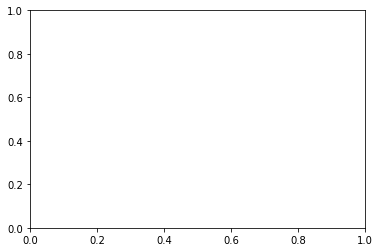

In [81]:
for file in files:
    f_full = join('./graphs/', file)
    with open(f_full, 'rb') as f:
        data = pickle.load(f)
    name_long = file[:-4]
    name_short = file[:4]
    save_path = './graphs/plotted_graphs/{}.png'.format(name_long)
    make_graph([0,1,2,3], data, name_long, name_short, save_path)